In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib as mpl
mpl.use('TkAgg')
from matplotlib import pyplot as plt
import tempfile
import os
import sys
%matplotlib inline

In [2]:
import networkx as nx
import community


In [3]:
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


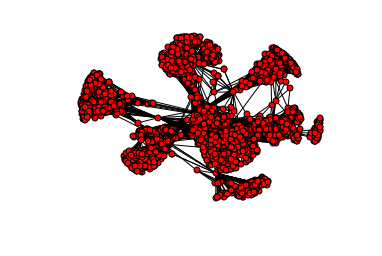

In [6]:
spring_pos = nx.spring_layout(G_fb)
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)


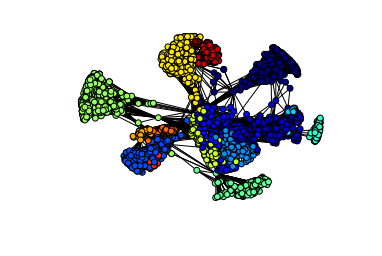

In [7]:
parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)


In [36]:
df = np.loadtxt("facebook_combined.txt")
idx = np.random.randint(low=0,high=df.shape[0], size=5000)

In [38]:
idx.sort()

In [39]:
idx

array([    1,    42,    47, ..., 88201, 88207, 88209])

In [40]:
df = df[idx]

In [41]:
df

array([[  0.00000000e+00,   2.00000000e+00],
       [  0.00000000e+00,   4.30000000e+01],
       [  0.00000000e+00,   4.80000000e+01],
       ..., 
       [  4.01300000e+03,   4.02300000e+03],
       [  4.01400000e+03,   4.03000000e+03],
       [  4.01400000e+03,   4.03800000e+03]])

In [42]:
np.savetxt("facebook_combined_small.txt",df,fmt="%d")

In [43]:
G_fb = nx.read_edgelist("facebook_combined_small.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_fb)

Name: 
Type: Graph
Number of nodes: 2792
Number of edges: 4862
Average degree:   3.4828


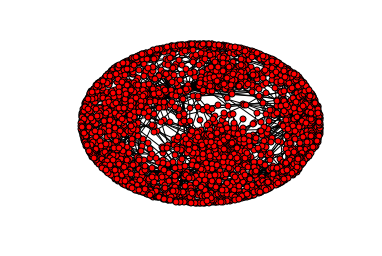

In [44]:
spring_pos = nx.spring_layout(G_fb)
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)


In [ ]:
parts = community.best_partition(G_fb)
values = [parts.get(node) for node in G_fb.nodes()]
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)
